참고
* https://www.one-tab.com/page/X_GE8G4pRY6Y1DQgexbpiQ
* 2019 ML month 2nd - base의 사본의 사본
* House_Price_Prediction_20190323_01_done
* http://www.brightics.ai/kr/docs/ai/v3.6/tutorials/45_2_energy_usage_analysis

그라디언부스팅검색
* https://blog.naver.com/960125_hds/221046332248

로버스트 검색
* https://blog.naver.com/ssdyka/221258155771

In [1]:
#!kaggle competitions download -c 2019-2nd-ml-month-with-kakr

from google.colab import *
auth.authenticate_user()
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install --upgrade pip
!pip install --upgrade scipy
!pip install plotnine

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
import lightgbm as lgb
from sklearn.decomposition import PCA

from time import time, localtime

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree  import DecisionTreeRegressor

from sklearn.metrics import explained_variance_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import mean_squared_error

%matplotlib inline

from plotnine import *
# from shap import TreeExplainer, summary_plot

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.0.3)
Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (1.2.1)


## Google Sheets

* https://gspread.readthedocs.io/en/latest/user-guide.html
* https://developers.google.com/sheets/api/quickstart/python
* https://colab.research.google.com/notebooks/io.ipynb#scrollTo=JiJVCmu3dhFa
* https://github.com/burnash/gspread
* https://www.youtube.com/watch?v=vISRn5qFrkM
* https://www.twilio.com/blog/2017/02/an-easy-way-to-read-and-write-to-a-google-spreadsheet-in-python.html?utm_source=youtube&utm_medium=video&utm_campaign=youtube_python_google_sheets

### my
* https://docs.google.com/spreadsheets/d/1Dq-peofoLFtqVT0TXm9_VCZa93BW5lkUP52uhw6J1qc/edit#gid=1701513987

In [0]:
!pip install --upgrade -q gspread

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

### Creating a Spreadsheet

In [0]:
worksheet = gc.create('2019-2nd-ml-month-with-kakr')

### Creating a Worksheet

In [0]:
worksheet = worksheet.add_worksheet(title="myfirst", rows="1000", cols="20")

#### or Opening

In [0]:
worksheet = gc.open('2019-2nd-ml-month-with-kakr').sheet1

### Basic Usage

In [6]:
worksheet_rows = worksheet.get_all_values()
gs_worksheet = pd.DataFrame.from_records(worksheet_rows)
gs_worksheet.head()

,0,1,2,3,4,5,6
0,N,Day,Main_Model,Para,Scaler,Score,
1,2,03/23,GradientBoostingRegressor,"n_estimators=400, max_depth=5, loss='ls', min_...",MaxAbsScaler,12267766897,
2,38,03/23,GradientBoostingRegressor,"GradientBoostingRegressor(alpha=0.9, criterion...",MaxAbsScaler,13001897071,
3,30,03/23,GradientBoostingRegressor,"GradientBoostingRegressor(alpha=0.9, criterion...",MaxAbsScaler,13103439913,
4,39,03/23,GradientBoostingRegressor,"GradientBoostingRegressor(alpha=0.9, criterion...",StandardScaler,13429694268,


In [0]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 1000

# Data Load

In [0]:
RANDOM_SEED = 631
np.random.seed(RANDOM_SEED)

In [0]:
train = pd.read_csv("./gdrive/My Drive/!DataSets/2019-2nd-ml-month-with-kakr/train.csv", index_col=0)
test = pd.read_csv("./gdrive/My Drive/!DataSets/2019-2nd-ml-month-with-kakr/test.csv", index_col=0)

In [10]:
print(train.shape, train.isnull().sum().sum())
print(test.shape, test.isnull().sum().sum())

(15035, 20) 0
(6468, 19) 0


In [0]:
price_raw = train['price']
train.drop('price', axis = 1, inplace=True)

In [12]:
print(train.shape, train.isnull().sum().sum())
print(test.shape, test.isnull().sum().sum())

(15035, 19) 0
(6468, 19) 0


In [13]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# Pre-processing

In [0]:
def clean_data(dataset):
    # Explo data
    # print('Raw Dataset shape :'.ljust(36), 'col', dataset.shape[0], 'row', dataset.shape[1])
    null_list = {}
    for i in train.columns:
        colnull = train[i].isnull().sum()
        if not colnull == 0:
            null_list[i] = colnull
    # print('missing value colnames and counts : '.ljust(36), null_list)

    # date column
    dataset['data_y'] = ''
    dataset['data_m'] = ''
    dataset['data_y'] = dataset['date'].apply(lambda x : str(x[:4])).astype(int)
    dataset['data_m'] = dataset['date'].apply(lambda x : str(x[4:6])).astype(int)
    dataset.drop('date', axis=1, inplace=True)
    # print('date dropped Dataset shape :'.ljust(36), 'col', dataset.shape[0], 'row', dataset.shape[1])

    # type check
    # for i in dataset.columns:
    #     colty = dataset[i].dtype
    #     if not colty == 'int64' and not colty == 'float64':
    #         print(i.ljust(15),'column is a', str(dataset[i].dtype).ljust(8), 'type')
    return dataset

In [0]:
cleaned_train = clean_data(train)
cleaned_test = clean_data(test)

## GEO

In [27]:
cleaned_train['zipcode'].head()

id
0    98178
1    98028
2    98074
3    98003
4    98198
Name: zipcode, dtype: object

In [0]:
def geogege(data):
  data['zipcode'] = data['zipcode'].astype(str)  
  data['zipcode-3'] = data['zipcode'].apply(lambda x : str(x[2:3])).astype(int)
  data['zipcode-4'] = data['zipcode'].apply(lambda x : str(x[3:4])).astype(int)
  data['zipcode-5'] = data['zipcode'].apply(lambda x : str(x[4:5])).astype(int)
  data['zipcode-34'] = data['zipcode'].apply(lambda x : str(x[2:4])).astype(int)
  data['zipcode-45'] = data['zipcode'].apply(lambda x : str(x[3:5])).astype(int)
  data['zipcode-35'] = data['zipcode'].apply(lambda x : str(x[2:5])).astype(int)
  data.drop('zipcode', axis=1, inplace=True)
  return data

In [0]:
geoge_train = geogege(cleaned_train)
geoge_test = geogege(cleaned_test)

In [36]:
geoge_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,data_y,data_m,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650,2014,10,1,7,8,17,78,178
1,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062,2015,2,0,2,8,2,28,28
2,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503,2015,2,0,7,4,7,74,74
3,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,2238,6819,2014,6,0,0,3,0,3,3
4,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,47.4095,-122.315,1650,9711,2015,1,1,9,8,19,98,198


## Transforming Skewed Continuous Features

In [0]:
def Skewed_CF(dataset):
  skewed = ['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'sqft_above', 'sqft_basement']
  features_log_transformed = pd.DataFrame(data = dataset)
  features_log_transformed[skewed] = dataset[skewed].apply(lambda x: np.log(x + 1))
  return features_log_transformed

In [0]:
Skewed_train = Skewed_CF(geoge_train)
Skewed_test = Skewed_CF(geoge_test)

In [137]:
Skewed_test.shape

(6468, 25)

In [87]:
Skewed_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,data_y,data_m,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,-1.666667,-0.850896,-0.400570,-0.5,0.0,0.0,0.0,0.0,-0.464395,0.0,-0.434783,0.0,-0.295233,-0.128713,-0.715791,-0.441200,0.0,0.8,1.0,1.00,0.75,1.375,1.153846,1.345238
1,-1.0,-1.666667,-1.648340,0.353689,-0.5,0.0,0.0,0.0,-1.0,-1.189913,0.0,-0.913043,0.0,0.807393,-0.009901,0.820922,0.083952,1.0,-0.8,0.0,-0.25,0.75,-0.500,-0.128205,-0.440476
2,0.0,-0.333333,-0.221959,0.077083,-0.5,0.0,0.0,0.0,1.0,0.107814,0.0,0.260870,0.0,0.218385,0.920792,-0.059753,-0.020678,1.0,-0.8,0.0,1.00,-0.25,0.125,1.051282,0.107143
3,0.0,0.000000,-0.186064,-0.147309,0.5,0.0,0.0,0.0,0.0,0.140471,0.0,0.434783,0.0,-1.275292,-0.475248,0.410026,-0.161039,0.0,0.0,0.0,-0.75,-0.50,-0.750,-0.769231,-0.738095
4,0.0,-1.000000,-1.047238,0.315985,-0.5,0.0,0.0,0.0,0.0,-0.643028,0.0,-0.260870,0.0,-0.789883,-0.415842,-0.250792,0.351464,1.0,-1.0,1.0,1.50,0.75,1.625,1.666667,1.583333


## Normalizing Numerical Features

In [61]:
for i in Skewed_train.columns:
  colty = Skewed_train[i].dtype
  if not colty == 'int64' and not colty == 'float64':
    print(i.ljust(15),'column is a', str(Skewed_train[i].dtype).ljust(8), 'type')
    
Skewed_train.drop('pca1', axis=1, inplace=True)
Skewed_train.drop('pca2', axis=1, inplace=True)


pca1            column is a object   type
pca2            column is a object   type


In [0]:
def scaler_dummy(dataset,aaa):

  scaler_mm = MinMaxScaler() 
  scaler_ma = MaxAbsScaler()
  scaler_sd = StandardScaler()
  scaler_rb = RobustScaler()

  numerical = list(dataset.columns)
  data_transform_mm = pd.DataFrame(data = dataset)
  data_transform_ma = pd.DataFrame(data = dataset)
  data_transform_sd = pd.DataFrame(data = dataset)
  data_transform_rb = pd.DataFrame(data = dataset)


  if aaa == 'train':    
    scaler_mm.fit(dataset[numerical])
    scaler_ma.fit(dataset[numerical])
    scaler_sd.fit(dataset[numerical])
    scaler_rb.fit(dataset[numerical])
    print('fit only train')


  data_transform_mm[numerical] = scaler_mm.transform(dataset[numerical])
  data_transform_ma[numerical] = scaler_ma.transform(dataset[numerical])
  data_transform_sd[numerical] = scaler_sd.transform(dataset[numerical])
  data_transform_rb[numerical] = scaler_rb.transform(dataset[numerical])


  ## get dummies

  features_final_mm = pd.get_dummies(data_transform_mm)
  features_final_ma = pd.get_dummies(data_transform_ma)
  features_final_sd = pd.get_dummies(data_transform_sd)
  features_final_rb = pd.get_dummies(data_transform_rb)

  return features_final_mm, features_final_ma, features_final_sd, features_final_rb

In [0]:
def scaler_dummy(dataset,aaa):

  scaler_mm = MinMaxScaler() 
  scaler_ma = MaxAbsScaler()
  scaler_sd = StandardScaler()
  scaler_rb = RobustScaler()

  numerical = list(dataset.columns)
  data_transform_mm = pd.DataFrame(data = dataset)
  data_transform_ma = pd.DataFrame(data = dataset)
  data_transform_sd = pd.DataFrame(data = dataset)
  data_transform_rb = pd.DataFrame(data = dataset)


  if aaa == 'train':    
    data_transform_mm[numerical] = scaler_mm.fit_transform(dataset[numerical])
    data_transform_ma[numerical] = scaler_ma.fit_transform(dataset[numerical])
    data_transform_sd[numerical] = scaler_sd.fit_transform(dataset[numerical])
    data_transform_rb[numerical] = scaler_rb.fit_transform(dataset[numerical])
#     scaler_mm.fit(dataset[numerical])
#     scaler_ma.fit(dataset[numerical])
#     scaler_sd.fit(dataset[numerical])
#     scaler_rb.fit(dataset[numerical])
    print('fit only train')


  data_transform_mm[numerical] = scaler_mm.transform(dataset[numerical])
  data_transform_ma[numerical] = scaler_ma.transform(dataset[numerical])
  data_transform_sd[numerical] = scaler_sd.transform(dataset[numerical])
  data_transform_rb[numerical] = scaler_rb.transform(dataset[numerical])


  ## get dummies

  features_final_mm = pd.get_dummies(data_transform_mm)
  features_final_ma = pd.get_dummies(data_transform_ma)
  features_final_sd = pd.get_dummies(data_transform_sd)
  features_final_rb = pd.get_dummies(data_transform_rb)

  return features_final_mm, features_final_ma, features_final_sd, features_final_rb

In [0]:
scaler_sd = StandardScaler()
numerical = list(Skewed_train.columns)
scaler_sd_fitted = scaler_sd.fit_transform(Skewed_train[numerical])
scaler_sd_fitted = pd.DataFrame(data = scaler_sd_fitted, columns=numerical)
features_final_train = pd.get_dummies(scaler_sd_fitted)

In [99]:
features_final_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,data_y,data_m,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,-0.408931,-1.452865,-1.126725,-0.362680,-0.924917,-0.084662,-0.306875,-0.62902,-0.560048,-0.746515,-0.801427,-0.547510,-0.209296,-0.358430,-0.306626,-1.043136,-0.372462,-0.685449,1.100821,1.182501,1.521182,1.189758,1.845297,1.622299,1.875717
1,-1.516730,-1.452865,-2.212637,0.288743,-0.924917,-0.084662,-0.306875,-0.62902,-1.407676,-1.811291,-0.801427,-1.295641,-0.209296,1.282425,-0.136763,1.112308,0.081855,1.458897,-1.474635,-0.845665,-0.446315,1.189758,-1.009381,-0.324570,-0.938751
2,-0.408931,-0.149923,-0.270276,0.049849,-0.924917,-0.084662,-0.306875,-0.62902,0.287579,0.093264,-0.801427,0.540680,-0.209296,0.405903,1.193836,-0.122956,-0.008661,1.458897,-1.474635,-0.845665,1.521182,-0.393147,-0.057821,1.466550,-0.075648
3,-0.408931,0.175813,-0.221398,-0.143949,0.932080,-0.084662,-0.306875,-0.62902,-0.560048,0.141191,-0.801427,0.812727,-0.209296,-1.816888,-0.802062,0.535971,-0.130090,-0.685449,-0.186907,-0.845665,-1.233314,-0.788873,-1.390004,-1.298004,-1.407829
4,-0.408931,-0.801394,-1.394092,0.256179,-0.924917,-0.084662,-0.306875,-0.62902,-0.560048,-1.008678,-0.801427,-0.275463,-0.209296,-1.094536,-0.717130,-0.390913,0.313284,1.458897,-1.796567,1.182501,2.308181,1.189758,2.225921,2.401047,2.250979


In [0]:
scaler_sd_fitted_test = scaler_sd.transform(Skewed_test[numerical])
scaler_sd_fitted_test = pd.DataFrame(data = scaler_sd_fitted_test,columns=numerical)
features_final_test = pd.get_dummies(scaler_sd_fitted_test)

In [139]:
features_final_test.shape

(6468, 25)

## Feature Scaling - PCA

In [0]:
# def ppccaa(dataset, aaa):
# #   dataset['pca1']= ''
# #   dataset['pca2']= ''
  
#   if aaa == 'train':
#     pca = PCA(n_components=2)
#     pca.fit(dataset)
#     print('fit only train')  
#   principalComponents_updated = pca.transform(dataset)


#   dataset['pca1']= principalComponents_updated[:, 0]
#   dataset['pca2']= principalComponents_updated[:, 1]
      
#   return dataset

# cleaned_pca_train = ppccaa(cleaned_train, 'train')
# cleaned_pca_test = ppccaa(cleaned_test, 'test')

In [0]:
features_final_train.drop('pca1', axis=1, inplace=True)
features_final_train.drop('pca2', axis=1, inplace=True)

for i in features_final_train.columns:
  colty = features_final_train[i].dtype
  if not colty == 'int64' and not colty == 'float64':
    print(i.ljust(15),'column is a', str(features_final_train[i].dtype).ljust(8), 'type')

In [0]:
# Skewed_train.drop('pca1', axis=1, inplace=True)
# Skewed_train.drop('pca2', axis=1, inplace=True)

pca = PCA(n_components=2)
principalComponents_updated = pca.fit_transform(features_final_train)

features_final_train['pca1']= ''
features_final_train['pca2']= ''
features_final_train['pca1']= principalComponents_updated[:, 0]
features_final_train['pca2']= principalComponents_updated[:, 1]

In [114]:
features_final_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,data_y,data_m,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35,pca1,pca2
0,-0.408931,-1.452865,-1.126725,-0.362680,-0.924917,-0.084662,-0.306875,-0.62902,-0.560048,-0.746515,-0.801427,-0.547510,-0.209296,-0.358430,-0.306626,-1.043136,-0.372462,-0.685449,1.100821,1.182501,1.521182,1.189758,1.845297,1.622299,1.875717,-3.264087,1.541078
1,-1.516730,-1.452865,-2.212637,0.288743,-0.924917,-0.084662,-0.306875,-0.62902,-1.407676,-1.811291,-0.801427,-1.295641,-0.209296,1.282425,-0.136763,1.112308,0.081855,1.458897,-1.474635,-0.845665,-0.446315,1.189758,-1.009381,-0.324570,-0.938751,-2.029374,-2.678414
2,-0.408931,-0.149923,-0.270276,0.049849,-0.924917,-0.084662,-0.306875,-0.62902,0.287579,0.093264,-0.801427,0.540680,-0.209296,0.405903,1.193836,-0.122956,-0.008661,1.458897,-1.474635,-0.845665,1.521182,-0.393147,-0.057821,1.466550,-0.075648,0.615950,-0.302400
3,-0.408931,0.175813,-0.221398,-0.143949,0.932080,-0.084662,-0.306875,-0.62902,-0.560048,0.141191,-0.801427,0.812727,-0.209296,-1.816888,-0.802062,0.535971,-0.130090,-0.685449,-0.186907,-0.845665,-1.233314,-0.788873,-1.390004,-1.298004,-1.407829,1.079230,-2.358063
4,-0.408931,-0.801394,-1.394092,0.256179,-0.924917,-0.084662,-0.306875,-0.62902,-0.560048,-1.008678,-0.801427,-0.275463,-0.209296,-1.094536,-0.717130,-0.390913,0.313284,1.458897,-1.796567,1.182501,2.308181,1.189758,2.225921,2.401047,2.250979,-2.906851,2.111070


In [0]:
principalComponents_updated_test = pca.transform(features_final_test)

features_final_test['pca1']= ''
features_final_test['pca2']= ''
features_final_test['pca1']= principalComponents_updated_test[:, 0]
features_final_test['pca2']= principalComponents_updated_test[:, 1]

In [141]:
features_final_test.shape

(6468, 27)

# Exploratory Data Analysis

In [0]:
# X_train, X_test, y_train, y_test = train_test_split(sd, price_raw, test_size = 0.1, random_state=RANDOM_SEED)
# price_raw_log = np.log1p(price_raw)

df_train_target = np.log1p(price_raw)
df_train_features = features_final_train

In [0]:
def print_best_params(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=5,
        scoring='neg_mean_squared_error')

    grid_model.fit(df_train_features, df_train_target)
    #     grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

## LightGBM

In [0]:
lgb_params6 = {'num_leaves': [10],
         'min_data_in_leaf': [10], 
         'objective':['regression'],
         'max_depth': [-1],
         'learning_rate': [0.05],
         "min_child_samples": [10],
         "boosting": ["gbdt"],
         "feature_fraction": [0.9],
         "bagging_freq": [1],
         "bagging_fraction": [0.9] ,
         "bagging_seed": [11],
         "metric": ['rmse'],
         "lambda_l1": [0.1],
         "verbosity": [-1],
         "nthread": [4],
         'n_estimators':[5000],
             'max_bin' : [100],
         'refit':[True], 
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
         "random_state": [RANDOM_SEED]}

In [123]:
lgb_model = lgb.LGBMRegressor()
lgb_estimator = print_best_params(lgb_model, lgb_params6)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값 0.1608, 최적 alpha:{'bagging_fraction': 0.9, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.9, 'lambda_l1': 0.1, 'learning_rate': 0.05, 'max_bin': 100, 'max_depth': -1, 'metric': 'rmse', 'min_child_samples': 10, 'min_data_in_leaf': 10, 'n_estimators': 5000, 'nthread': 4, 'num_leaves': 10, 'objective': 'regression', 'predictor': 'gpu_predictor', 'random_state': 631, 'refit': True, 'tree_method': 'gpu_hist', 'verbosity': -1}


In [124]:
lgb_estimator

LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.9, importance_type='split',
       lambda_l1=0.1, learning_rate=0.05, max_bin=100, max_depth=-1,
       metric='rmse', min_child_samples=10, min_child_weight=0.001,
       min_data_in_leaf=10, min_split_gain=0.0, n_estimators=5000,
       n_jobs=-1, nthread=4, num_leaves=10, objective='regression',
       predictor='gpu_predictor', random_state=631, refit=True,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, tree_method='gpu_hist',
       verbosity=-1)

## xgboost 

In [125]:
xgb_params_add1 ={
    'seed': [RANDOM_SEED],
    'learning_rate': [0.05],
    'max_depth': [5],
    'subsample': [0.9],
    'colsample_bytree': [0.4],
    'silent': [True],
    'gpu_id':[0] ,         
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'n_estimators':[5000],
    'refit' : [True]
}
xgb_model = xgb.XGBRegressor() 

xgb_estimator = print_best_params(xgb_model, xgb_params_add1)



XGBRegressor 5 CV 시 최적 평균 RMSE 값 0.1618, 최적 alpha:{'colsample_bytree': 0.4, 'gpu_id': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 5000, 'predictor': 'gpu_predictor', 'refit': True, 'seed': 631, 'silent': True, 'subsample': 0.9, 'tree_method': 'gpu_hist'}


In [126]:
xgb_estimator

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, gpu_id=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=5000, n_jobs=1,
       nthread=None, objective='reg:linear', predictor='gpu_predictor',
       random_state=0, refit=True, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=631, silent=True, subsample=0.9,
       tree_method='gpu_hist')

# ensemble

In [0]:
xgb_preds = xgb_estimator.predict(features_final_test)
lgb_preds = lgb_estimator.predict(features_final_test)
preds = 0.5* xgb_preds + 0.5*lgb_preds

In [143]:
preds_last = np.exp(preds)
preds_last.shape

(6468,)

In [0]:
submission = pd.read_csv("./gdrive/My Drive/!DataSets/2019-2nd-ml-month-with-kakr/sample_submission.csv")
submission['price']= preds_last
submission.to_csv('sub04_xgb_lgbm.csv',index=False)

# 미정리

In [135]:
features_final_test.shape

(15035, 27)

In [0]:
def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    error = np.expm1(predictions) - np.expm1(labels)
    squared_error = np.square(error)
    mean = np.mean(squared_error)
    return ('rmse_exp', np.sqrt(mean))

In [0]:
xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.4,
#     'tree_method': 'gpu_hist',    # 최적화된 분할 지점을 찾기 위한 algorithm 설정 + 캐글의 GPU 사용
#     'predictor': 'gpu_predictor', # 예측 시에도 GPU사용
    'objective': 'reg:linear',    # 회귀
    'eval_metric': 'rmse',        # kaggle에서 요구하는 검증모델
    'silent': True,               # 학습 동안 메세지 출력할지 말지
    'seed': RANDOM_SEED,
}

In [0]:
# X_train, X_test, y_train, y_test

%%time
# transforming
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)


# cross validation
cv_output = xgb.cv(xgb_params,
                   dtrain,                        
                   num_boost_round=15000,         # the number of boosting trees
                   early_stopping_rounds=100,    # val loss가 계속 상승하면 중지
                   nfold=5,                      # set folds of the closs validation
                   verbose_eval=300,             # 몇 번째마다 메세지를 출력할 것인지
#                    feval=rmse_exp,               # price 속성을 log scaling 했기 때문에, 다시 exponential
                   maximize=False,
                   show_stdv=False,              # 학습 동안 std(표준편차) 출력할지 말지
                   )

[0]	train-rmse:641878	test-rmse:641916
[300]	train-rmse:94142.4	test-rmse:134183
[600]	train-rmse:81041.3	test-rmse:127878
[900]	train-rmse:74611.1	test-rmse:125845
[1200]	train-rmse:69281.9	test-rmse:124515
[1500]	train-rmse:64973	test-rmse:123729
[1800]	train-rmse:61006.4	test-rmse:123085
[2100]	train-rmse:57804.2	test-rmse:122630
[2400]	train-rmse:54893.4	test-rmse:122271
[2700]	train-rmse:52288.2	test-rmse:122030
[3000]	train-rmse:49816.3	test-rmse:121772
[3300]	train-rmse:47571	test-rmse:121579
[3600]	train-rmse:45523.8	test-rmse:121384
[3900]	train-rmse:43625.5	test-rmse:121240
[4200]	train-rmse:41945.2	test-rmse:121158
[4500]	train-rmse:40307.4	test-rmse:121079
[4800]	train-rmse:38751.3	test-rmse:121037
[5100]	train-rmse:37266.1	test-rmse:120973
[5400]	train-rmse:35880.4	test-rmse:120947
[5700]	train-rmse:34543.3	test-rmse:120906
[6000]	train-rmse:33360.9	test-rmse:120894
[6300]	train-rmse:32208.7	test-rmse:120870
[6600]	train-rmse:31128.2	test-rmse:120849
[6900]	train-rmse:3010

In [0]:
cv_output = xgb.cv(xgb_params,
                   dtrain,                        
                   num_boost_round=50000,         # the number of boosting trees
                   early_stopping_rounds=1000,    # val loss가 계속 상승하면 중지
                   nfold=5,                      # set folds of the closs validation
                   verbose_eval=500,             # 몇 번째마다 메세지를 출력할 것인지
#                    feval=rmse_exp,               # price 속성을 log scaling 했기 때문에, 다시 exponential
                   maximize=False,
                   show_stdv=False,              # 학습 동안 std(표준편차) 출력할지 말지
#                    seed=RANDOM_SEED
                   )

[0]	train-rmse:641878	test-rmse:641916
[500]	train-rmse:83879	test-rmse:128993
[1000]	train-rmse:72696.5	test-rmse:125351
[1500]	train-rmse:64973	test-rmse:123729
[2000]	train-rmse:58880.3	test-rmse:122792
[2500]	train-rmse:53963.4	test-rmse:122201
[3000]	train-rmse:49816.3	test-rmse:121772
[3500]	train-rmse:46218.8	test-rmse:121449
[4000]	train-rmse:43057.6	test-rmse:121227
[4500]	train-rmse:40307.4	test-rmse:121079
[5000]	train-rmse:37808.3	test-rmse:120983
[5500]	train-rmse:35446.4	test-rmse:120941
[6000]	train-rmse:33360.9	test-rmse:120894
[6500]	train-rmse:31480.1	test-rmse:120851
[7000]	train-rmse:29777.4	test-rmse:120787
[7500]	train-rmse:28200.2	test-rmse:120752
[8000]	train-rmse:26637.4	test-rmse:120742
[8500]	train-rmse:25295.4	test-rmse:120747


In [0]:
best_rounds = cv_output.index.size
print(f'\nBest Rounds: {best_rounds}')

score = round(cv_output.iloc[-1]['test-rmse-mean'], 2)
print(f'Best Score: {score}')


Best Rounds: 7609
Best Score: 120736.32


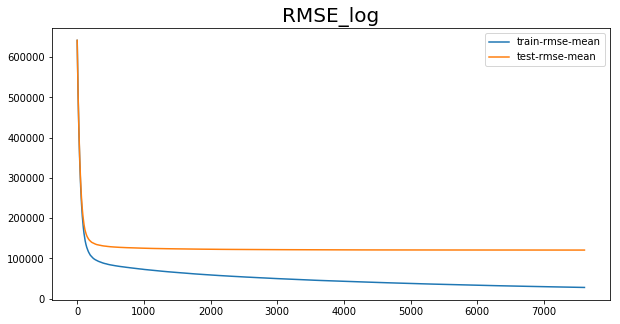

In [0]:
# plotting
# fig, ax1 = plt.plot()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
# fig, (ax1) = plt.subplots(1, 1, figsize=(10,5))
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot(ax=ax1)
ax1.set_title('RMSE_log', fontsize=20)
cv_output[['train-rmse_exp-mean', 'test-rmse_exp-mean']].plot(ax=ax2)
ax2.set_title('RMSE', fontsize=20)

plt.show()

In [0]:
model = xgb.train(xgb_params, dtrain, num_boost_round=best_rounds)
y_pred = model.predict(dtest)

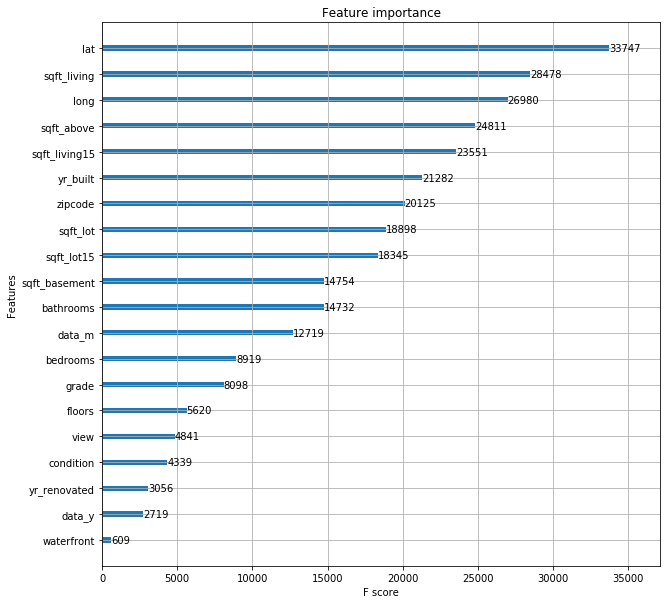

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)

plt.show()

In [0]:
# from shapely.geometry import shape, Point, multipolygon
# from shap import TreeExplainer, summary_plot

# explainer = TreeExplainer(model)
# shap_values = explainer.shap_values(X_train)
# summary_plot(shap_values, X_train, title='Train')

In [0]:
X_train, X_test, y_train, y_test = train_test_split(sd, price_raw, test_size = 0.1, random_state=RANDOM_SEED)



start = time()
est = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
           learning_rate=0.1, loss='ls', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200,
           n_iter_no_change=None, presort='auto', random_state=RANDOM_SEED,
           subsample=1.0, tol=0.1, validation_fraction=0.1, verbose=0)

est.fit(X_train, y_train)

end = time()
time_d = end - start

# pridict
pred_est = est.predict(X_test)
# pred_est = np.expm1(pred_est)
get_para_gbr = est.get_params

rmse_est_gbr = mean_squared_error(pred_est, y_test)
print(rmse_est_gbr)



# score_mm = tt(mm) 11810252014.834291
# score_ma = tt(ma) 12185041267.04306
# score_sd = tt(sd) 11494035306.350412
# score_rb = tt(rb) 11810252014.834291

# 결정 sd 11494035306



11494035306.350412


In [0]:
xgb_params1 = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.9,
    'colsample_bytree': 0.5,
#     'tree_method': 'gpu_hist',    # 최적화된 분할 지점을 찾기 위한 algorithm 설정 + 캐글의 GPU 사용
    'predictor': 'gpu_predictor', # 예측 시에도 GPU사용
    'objective': 'reg:linear',    # 회귀
    'eval_metric': 'rmse',        # kaggle에서 요구하는 검증모델
    'silent': True,               # 학습 동안 메세지 출력할지 말지
    'seed': RANDOM_SEED,
    'n_estimators':1000
}

%%time
# transforming
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

# cross validation
cv_output = xgb.cv(xgb_params1,
                   dtrain,                        
                   num_boost_round=15000,         # the number of boosting trees
                   early_stopping_rounds=100,    # val loss가 계속 상승하면 중지
                   nfold=5,                      # set folds of the closs validation
                   verbose_eval=100,             # 몇 번째마다 메세지를 출력할 것인지
#                    feval=rmse_exp,               # price 속성을 log scaling 했기 때문에, 다시 exponential
                   maximize=False,
                   show_stdv=False,              # 학습 동안 std(표준편차) 출력할지 말지
                   )

[0]	train-rmse:624352	test-rmse:624571
[100]	train-rmse:106571	test-rmse:137675
[200]	train-rmse:94277.1	test-rmse:131165
[300]	train-rmse:88932.6	test-rmse:128867
[400]	train-rmse:85587.3	test-rmse:127815
[500]	train-rmse:82952.8	test-rmse:126880
[600]	train-rmse:80152	test-rmse:126179
[700]	train-rmse:77882.1	test-rmse:125595
[800]	train-rmse:75464.5	test-rmse:124977
[900]	train-rmse:73508.4	test-rmse:124537
[1000]	train-rmse:71837	test-rmse:124179
[1100]	train-rmse:69893.8	test-rmse:123943
[1200]	train-rmse:68268.5	test-rmse:123618
[1300]	train-rmse:66682.5	test-rmse:123439
[1400]	train-rmse:65134	test-rmse:123340
[1500]	train-rmse:63929.9	test-rmse:123123
[1600]	train-rmse:62632.4	test-rmse:122968
[1700]	train-rmse:61335.1	test-rmse:122881
[1800]	train-rmse:60169.4	test-rmse:122780
[1900]	train-rmse:59124.9	test-rmse:122677
[2000]	train-rmse:58147.7	test-rmse:122625
[2100]	train-rmse:57193.6	test-rmse:122550
[2200]	train-rmse:56198.8	test-rmse:122502
[2300]	train-rmse:55270	test-rm